In [69]:
#! pip install tensorflow -U

# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Вывод-консоли" data-toc-modified-id="Вывод-консоли-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод консоли</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Описание проекта

 Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя.  
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.  

**План выполнения проекта**  
Проведем исследовательский анализ набора фотографий.  
Подготовим данные к обучению.  
Обучим нейронную сеть и рассчитаем её качество  

## Загрузка данных

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 4113 validated image filenames.


## Исследовательский анализ данных

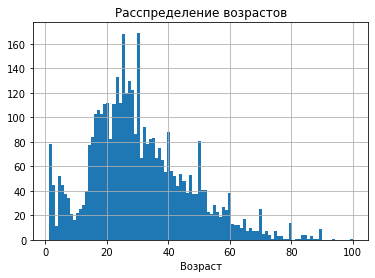

In [12]:
y_train['real_age'].hist(bins=100)
plt.title('Расспределение возрастов')
plt.xlabel('Возраст');

In [11]:
y_train.describe()

,real_age
count,4113.000000
mean,30.476052
std,16.312428
min,1.000000
25%,19.000000
50%,28.000000
75%,40.000000
max,100.000000


По графику видно, что больше всего фотографий людей в возрасте от 19 до 40 лет

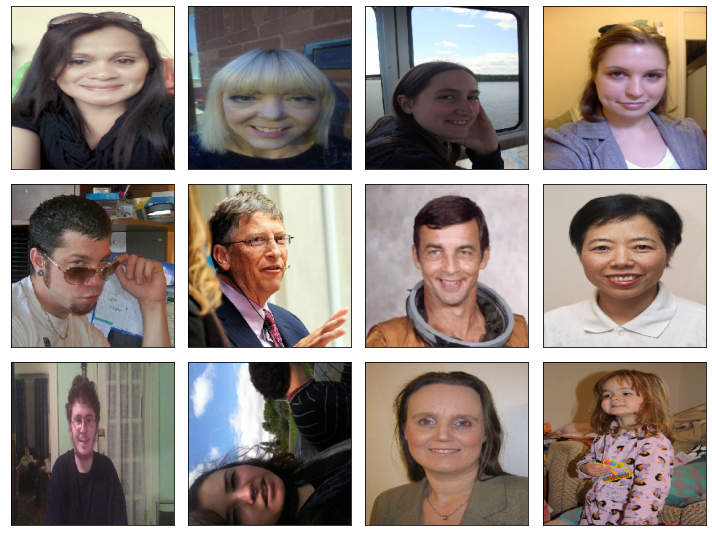

In [14]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях действительно люди...

## Обучение модели

In [17]:
#функция для загрузки тренировочной выборки
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow 
#функция для загрузки тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow


#функция для создания модели
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

#функция для обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Epoch 1/3
129/129 - 1760s - loss: 262.1931 - mae: 11.9595 - val_loss: 1449.2194 - val_mae: 32.8644 - 1760s/epoch - 14s/step
Epoch 2/3
129/129 - 1670s - loss: 65.7274 - mae: 6.3077 - val_loss: 1448.1797 - val_mae: 32.8468 - 1670s/epoch - 13s/step
Epoch 3/3
129/129 - 1664s - loss: 33.5085 - mae: 4.4571 - val_loss: 1378.2601 - val_mae: 31.7448 - 1664s/epoch - 13s/step
Wall time: 1h 24min 55s


### Вывод консоли

Found 5694 validated image filenames.  
Found 1897 validated image filenames.  
Train for 356 steps, validate for 119 steps  
Epoch 1/10  
356/356 - 69s - loss: 223.3599 - mae: 10.7732 - val_loss: 723.0913 - val_mae: 21.9060  
Epoch 2/10  
356/356 - 37s - loss: 70.5328 - mae: 6.3881 - val_loss: 246.6683 - val_mae: 12.2230  
Epoch 3/10  
356/356 - 38s - loss: 38.8670 - mae: 4.8427 - val_loss: 96.4585 - val_mae: 7.3461  
Epoch 4/10  
356/356 - 38s - loss: 24.1560 - mae: 3.7868 - val_loss: 133.2803 - val_mae: 9.3134  
Epoch 5/10  
356/356 - 37s - loss: 19.0013 - mae: 3.3630 - val_loss: 90.9621 - val_mae: 7.4871  
Epoch 6/10  
356/356 - 38s - loss: 13.9948 - mae: 2.8680 - val_loss: 73.9370 - val_mae: 6.5779  
Epoch 7/10  
356/356 - 38s - loss: 11.4461 - mae: 2.5764 - val_loss: 69.2121 - val_mae: 6.1712  
Epoch 8/10  
356/356 - 38s - loss: 12.1796 - mae: 2.6553 - val_loss: 71.6044 - val_mae: 6.4161  
Epoch 9/10  
356/356 - 38s - loss: 11.4181 - mae: 2.5374 - val_loss: 70.3961 - val_mae: 6.2951  
Epoch 10/10    
356/356 - 37s - loss: 10.8433 - mae: 2.4906 - val_loss: 65.9819 - val_mae: 6.0248  
119/119 - 9s - loss: 65.9819 - mae: 6.0248  
Test MAE: 6.0248  

В ходе обучения МАЕ нашей модели на тестовой выборке = 6.0248. Учитывая, что большинству людей в наших данных от 19 до 40 лет, то разброс не слишком большой (во всяком случае, я и того хуже предсказываю возраст)

## Вывод

Мы изучили данные супермаркета,   
исследовали распределение возрастов на фото,  
и обучили модель нейронной сети для предсказывания возраста по фото.  
МАЕ нашей модели = 6.0248.  